Greggs Vs Pret

---
---
---

In [1]:
import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests
import json
import pandas as pd

import matplotlib.pyplot as plt

#for legends
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import math
from matplotlib.lines import Line2D

import folium

use of overpass adopted from https://github.com/Lisa-Ho/30-day-map-challenge/blob/main/2023/Day3-london-pubs/london-pubs.ipynb

In [2]:
# get Greggs from OSM using Overpass API
overpass_url = 'http://overpass-api.de/api/interpreter'
overpass_query = '''
[out:json];
area["ISO3166-1"="GB"]->.searchArea;

(way["brand:wikidata"="Q3403981"](area.searchArea);  
node["brand:wikidata"="Q3403981"](area.searchArea);  
rel["brand:wikidata"="Q3403981"](area.searchArea); 
);
out center;

'''
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [4]:
# convert json into dataframe
df_dict = {'id':[], 'type': [], 'lat':[], 'lon': [],'name':[]}

for element in data['elements']:
    df_dict['id'].append(element['id'])
    df_dict['type'].append(element['type'])
    
    for tag in list(df_dict.keys())[4:]:
        try:
            df_dict[tag].append(element['tags'][tag])
        except KeyError:
            df_dict[tag].append('') 
    if element['type']=='node':
        df_dict['lat'].append(element['lat'])
        df_dict['lon'].append(element['lon'])
    else:
        df_dict['lat'].append(element['center']['lat'])
        df_dict['lon'].append(element['center']['lon'])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
greggs_gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [5]:
# get Prets from OSM using Overpass API
overpass_url = 'http://overpass-api.de/api/interpreter'
overpass_query = '''
[out:json];
area["ISO3166-1"="GB"]->.searchArea;

(way["brand:wikidata"="Q2109109"](area.searchArea);  
node["brand:wikidata"="Q2109109"](area.searchArea);  
rel["brand:wikidata"="Q2109109"](area.searchArea); 
);
out center;

'''
response = requests.get(overpass_url, params={'data': overpass_query})
pret_data = response.json()

In [6]:
# convert json into dataframe
df_dict = {'id':[], 'type': [], 'lat':[], 'lon': [],'name':[]}

for element in pret_data['elements']:
    df_dict['id'].append(element['id'])
    df_dict['type'].append(element['type'])
    
    for tag in list(df_dict.keys())[4:]:
        try:
            df_dict[tag].append(element['tags'][tag])
        except KeyError:
            df_dict[tag].append('') 
    if element['type']=='node':
        df_dict['lat'].append(element['lat'])
        df_dict['lon'].append(element['lon'])
    else:
        df_dict['lat'].append(element['center']['lat'])
        df_dict['lon'].append(element['center']['lon'])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
pret_gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [7]:
#append the greggs and pret dataframe
appended_df = greggs_gdf.append(pret_gdf, ignore_index=True)


C:\Users\EMoses\AppData\Local\Temp\ipykernel_18148\3652567341.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  appended_df = greggs_gdf.append(pret_gdf, ignore_index=True)


In [8]:
appended_df

id  type        lat       lon           name  \
0      140697749  node  51.498230 -0.135216         Greggs   
1      251977031  node  51.705522 -0.612239         Greggs   
2      290369386  node  51.236173 -0.575119         Greggs   
3      297118481  node  53.795863 -1.663838         Greggs   
4      313192446  node  52.480509 -1.897402         Greggs   
...          ...   ...        ...       ...            ...   
2272  1002485835   way  51.493027 -0.225577  Pret A Manger   
2273  1011408798   way  51.462382 -0.216090  Pret A Manger   
2274  1034909999   way  52.708407 -2.754437  Pret A Manger   
2275  1173090814   way  53.405376 -2.989652  Pret A Manger   
2276  1231081539   way  51.456620 -0.193150  Pret A Manger   

                       geometry  
0     POINT (-0.13522 51.49823)  
1     POINT (-0.61224 51.70552)  
2     POINT (-0.57512 51.23617)  
3     POINT (-1.66384 53.79586)  
4     POINT (-1.89740 52.48051)  
...                         ...  
2272  POINT (-0.22558 51.49303)  
2273  POINT (-0.21609 51.46238)  
2274  POINT (-2.75444 52.70841)  
2275  POINT (-2.98965 53.40538)  
2276  POINT (-0.19315 51.45662)  

[2277 rows x 6 columns]

In [9]:
# creating a folium map 

m = folium.Map(
    location=[52.595616, -1.336806], # start location as lat and lon
    tiles="CartoDB dark_matter", # adding a dark basemap
    zoom_start=7, # level of zoom
    prefer_canvas=True, # useful for changing the base map
)

# Create a dictionary to map names to colors
color_dict = {
    "Pret A Manger": '#8C240E',
    "Greggs": '#3186cc',
}

# Iterate through every row of the GeoDataFrame using the iterrows() function
for index, val in appended_df.iterrows():
    # Set color based on the value in the 'name' column, default to '#3186cc'
    fill_color = color_dict.get(val["name"])

    folium.CircleMarker(
        location=[val["geometry"].y, val["geometry"].x],  # Extracting lat and lon from Point geometry
        radius=5,
        popup=val["name"],
        color=fill_color,  # Outline color
        fill=True,
        fill_color=fill_color  # Fill color based on the 'name' column
    ).add_to(m)


m


In [10]:

# Save the map as an HTML file
m.save('index.html')

# Superseded

### Spatial clustering

'Clustering is the task of grouping a set of objects in such a way that observations in the same group are more similar to each other than to those in other groups. It is one of the most popular applications of the Unsupervised Learning (Machine Learning when there is no target variable).' as per: https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec

The elbow method is a technique used to determine the optimal number of clusters for a given dataset when using k-means clustering.

In [19]:
from sklearn import preprocessing, cluster
import scipy
import numpy as np
import seaborn as sns

### Spatial clustering for Pret

In [15]:
pret_gdf

id  type        lat       lon           name  \
0     268430894  node  51.507119 -0.107726  Pret A Manger   
1     275221458  node  55.864467 -4.254306  Pret A Manger   
2     281454982  node  51.520447 -0.116957  Pret A Manger   
3     282686489  node  51.506041 -0.117331  Pret A Manger   
4     290362214  node  51.236264 -0.574354  Pret A Manger   
..          ...   ...        ...       ...            ...   
375   997224975   way  51.494448 -0.212520  Pret A Manger   
376  1002485835   way  51.493027 -0.225577  Pret A Manger   
377  1011408798   way  51.462382 -0.216090  Pret A Manger   
378  1034909999   way  52.708407 -2.754437  Pret A Manger   
379  1173090814   way  53.405376 -2.989652  Pret A Manger   

                      geometry  
0    POINT (-0.10773 51.50712)  
1    POINT (-4.25431 55.86447)  
2    POINT (-0.11696 51.52045)  
3    POINT (-0.11733 51.50604)  
4    POINT (-0.57435 51.23626)  
..                         ...  
375  POINT (-0.21252 51.49445)  
376  POINT (-0.22558 51.49303)  
377  POINT (-0.21609 51.46238)  
378  POINT (-2.75444 52.70841)  
379  POINT (-2.98965 53.40538)  

[380 rows x 6 columns]

c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

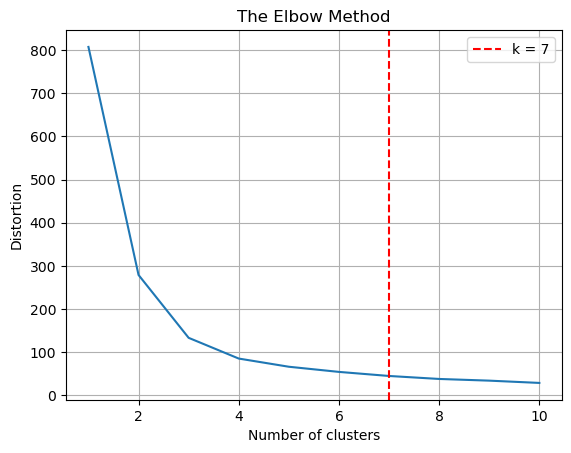

In [16]:

# the following code is adopted from Lecture 10 - Spatial Clustering

# determine the number of clusters using the Elbow method
X = pret_gdf[["lat","lon"]]
max_k = 10
# iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
# best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [23]:
#overwrting the k value 
k = 2

In [32]:
# creating the clusters 
model = cluster.KMeans(n_clusters=k, init='k-means++')
#X = sc_gdf[["lat","lon"]]
X = pret_gdf[["lon","lat"]]

# clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
    
# add clustering info to the original dataset, cluster label and centroid cluster label
pret_gdf[["cluster","centroids"]] = df_X[["cluster","centroids"]]
pret_gdf.sample(5)

c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\EMoses\AppData\Local\Temp\ipykernel_19948\2437346802.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X["centroids"].iloc[i] = 1


id  type        lat       lon           name  \
232  7625767043  node  51.534100 -0.105773  Pret A Manger   
315   294894101   way  51.520240 -0.134304  Pret A Manger   
78   1687103205  node  52.412883 -1.778085  Pret A Manger   
10    334644908  node  53.479793 -2.251861  Pret A Manger   
225  6561669261  node  51.531715 -0.125987  Pret A Manger   

                      geometry  cluster  centroids  
232  POINT (-0.10577 51.53410)        1          0  
315  POINT (-0.13430 51.52024)        1          0  
78   POINT (-1.77808 52.41288)        6          0  
10   POINT (-2.25186 53.47979)        0          0  
225  POINT (-0.12599 51.53171)        1          0

In [25]:
# number of elements per cluster
# using the groupby() and size() functions to reveal the number of clusters and the number of elements per cluster.
print(pret_gdf.groupby('cluster').size())

cluster
0    340
1     40
dtype: int64


Plot a folium map showing Ps now coloured by cluster ID and cluster's centroids.

In [26]:
# plotting the clustering and cluster centroids on a static plot

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x="lon", y="lat", data=pret_gdf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', #size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

In [27]:
# plotting the spatial clustering on an interactive map

map_ = folium.Map(
    location=[51.5074, -0.1272], # start location as lat and lon
    tiles="cartodbpositron", # adding a basemap
    zoom_start=12, # level of zoom
    prefer_canvas=True, # useful for changing the basemap
)

color = "cluster"
marker = "centroids"
data = pret_gdf.copy()

lst_elements = sorted(list(data[color].unique()))
#lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] # code to generate colours at random
lst_colors=["blue","orange","green","red","magenta", "brown","pink","yellow", "darkpurple","lightgreen", "gray", "black"] 
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

scaler = preprocessing.MinMaxScaler(feature_range=(3,15))

# add points
data.apply(lambda row: folium.CircleMarker(
           location=[row["lat"],row["lon"]],
           popup=row['name'], # for popup
           color=row["color"], fill=True).add_to(map_), axis=1)

  
# adding a html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))


# add centroids marker as an icon
lst_elements = sorted(list(data[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row["lat"],row["lon"]], 
           popup='<strong>'+'Cluster: ' + str(row['cluster']), 
            draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
# plot the map
map_

### Spatial clustering for Greggs

c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

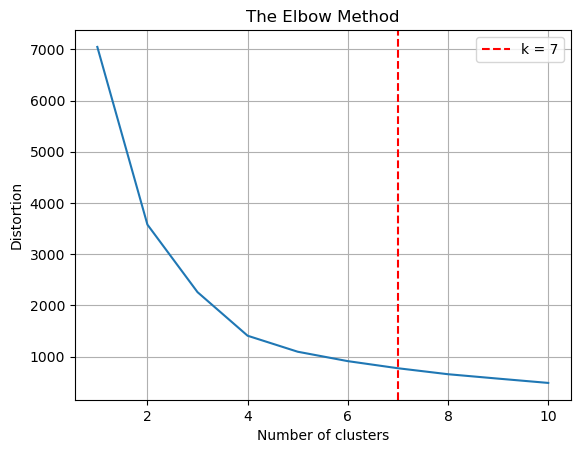

In [42]:

# the following code is adopted from Lecture 10 - Spatial Clustering

# determine the number of clusters using the Elbow method
X = greggs_gdf[["lat","lon"]]
max_k = 10
# iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
# best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [51]:
#overwrting the k value 
k = 2

In [52]:
# creating the clusters 
model = cluster.KMeans(n_clusters=k, init='k-means++')
#X = sc_gdf[["lat","lon"]]
X = greggs_gdf[["lon","lat"]]

# clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
    
# add clustering info to the original dataset, cluster label and centroid cluster label
greggs_gdf[["cluster","centroids"]] = df_X[["cluster","centroids"]]
greggs_gdf.sample(5)



c:\Users\EMoses\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\EMoses\AppData\Local\Temp\ipykernel_19948\2576902651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X["centroids"].iloc[i] = 1


id  type        lat       lon    name  \
371    3812387243  node  52.444785 -1.784902  Greggs   
1032  10029599378  node  51.317397 -2.207019  Greggs   
639    5624476967  node  54.058096 -2.801273  Greggs   
679    6049267170  node  53.705443 -2.325793  Greggs   
688    6147300290  node  51.490948  0.068322  Greggs   

                       geometry  cluster  centroids  
371   POINT (-1.78490 52.44478)        1          0  
1032  POINT (-2.20702 51.31740)        1          0  
639   POINT (-2.80127 54.05810)        0          0  
679   POINT (-2.32579 53.70544)        0          0  
688    POINT (0.06832 51.49095)        1          0

In [53]:
# number of elements per cluster
# using the groupby() and size() functions to reveal the number of clusters and the number of elements per cluster.
print(greggs_gdf.groupby('cluster').size())



cluster
0     641
1    1018
dtype: int64


C:\Users\EMoses\AppData\Local\Temp\ipykernel_19948\249563973.py:5: UserWarning: 
The palette list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x="lon", y="lat", data=pret_gdf,


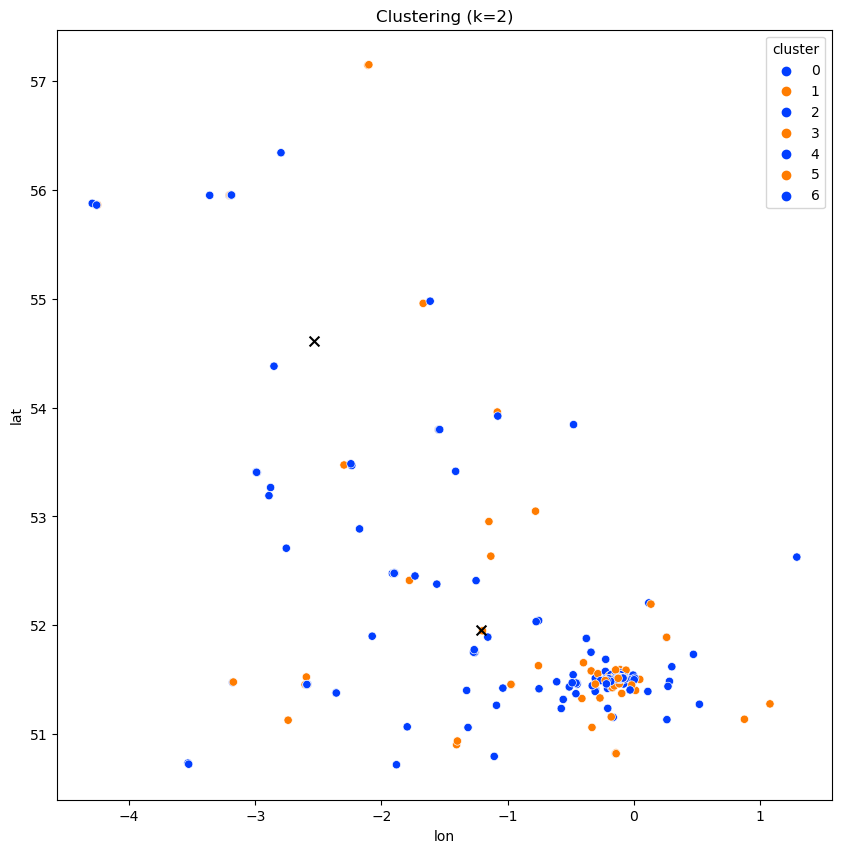

In [54]:

###
# plotting the clustering and cluster centroids on a static plot

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x="lon", y="lat", data=pret_gdf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', #size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

In [55]:
# plotting the spatial clustering on an interactive map

map_ = folium.Map(
    location=[51.5074, -0.1272], # start location as lat and lon
    tiles="cartodbpositron", # adding a basemap
    zoom_start=12, # level of zoom
    prefer_canvas=True, # useful for changing the basemap
)

color = "cluster"
marker = "centroids"
data = greggs_gdf.copy()

lst_elements = sorted(list(data[color].unique()))
#lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] # code to generate colours at random
lst_colors=["blue","orange","green","red","magenta", "brown","pink","yellow", "darkpurple","lightgreen", "gray", "black"] 
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

scaler = preprocessing.MinMaxScaler(feature_range=(3,15))

# add points
data.apply(lambda row: folium.CircleMarker(
           location=[row["lat"],row["lon"]],
           popup=row['name'], # for popup
           color=row["color"], fill=True).add_to(map_), axis=1)

  
# adding a html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))


# add centroids marker as an icon
lst_elements = sorted(list(data[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row["lat"],row["lon"]], 
           popup='<strong>'+'Cluster: ' + str(row['cluster']), 
            draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
# plot the map
map_

### GeoZ python library 

GeoZ is a python geovisualization library. The library focuses on mapping the output of clustering algorithms in geographical maps as regions instead of points.
So if you work with clustering algorithms, your data have geographical dimensions and you are looking to represent them as regions instead of color-coded points


Github: https://lnkd.in/d2jx3DbH
publication: https://lnkd.in/d46J8pV5
LinkedIn article summarizing the publication: https://lnkd.in/dCnjPU-T